# Saudi Arabian Interbank Offered Rate Forecast

#### **SAIBOR**(**S**audi **A**rabian **I**nterbank **O**ffered **R**ate): 
 is a daily reference rate, published by SAMA (Saudi Arabian Monetary Authority), based on the averaged interest rates at which Saudi banks offer to lend unsecured funds to other banks in the Saudi Riyal wholesale money market (or interbank market).
 
 
<https://en.wikipedia.org/wiki/SAIBOR>


In [313]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

### Exploratory data analysis

In [314]:
#read data file
SAIBOR = pd.pandas.read_excel('SAIBOR.xlsx')

In [315]:
#check first 30 rows
SAIBOR.head(30)

,Security,ANBR3M Index,Unnamed: 2
0,Start Date,2002-01-31 00:00:00,NaN
1,End Date,2019-08-29 00:00:00,NaN
2,Period,D,NaN
3,NaN,NaN,NaN
4,Date,PX_LAST,PX_BID
5,2019-08-29 00:00:00,2.44,NaN
6,2019-08-28 00:00:00,2.45,NaN
7,2019-08-27 00:00:00,2.45,NaN
8,2019-08-26 00:00:00,2.45,NaN
9,2019-08-25 00:00:00,2.45,NaN


In [316]:
#drop unnecessary few rows and columns. rename remaining columns with appropriate labels

SAIBOR = SAIBOR.iloc[5:,[0,1]].rename(columns={SAIBOR.columns[0]: "date", SAIBOR.columns[1]: "saibor"})

In [317]:
#set date as index 

SAIBOR['date'] = pd.to_datetime(SAIBOR['date'])

In [318]:
SAIBOR = SAIBOR.set_index('date')

In [319]:
SAIBOR.sort_index(inplace=True);

In [320]:
#check data types, change to float if necessary
SAIBOR.dtypes

saibor    object
dtype: object

In [321]:
SAIBOR.saibor =SAIBOR.saibor.astype(float)

In [322]:
SAIBOR.dtypes

saibor    float64
dtype: object

In [323]:
#check the descriptive statistics of the dataframe. look for outliers and remove them by forward filling
SAIBOR.describe()

,saibor
count,4052.000000
mean,2.014277
std,1.861691
min,0.265000
25%,0.880000
50%,1.730000
75%,2.640000
max,60.000000


In [324]:
SAIBOR.saibor.idxmax()

Timestamp('2005-09-29 00:00:00')

In [325]:
SAIBOR.loc['2005-09-29']

saibor    60.0
Name: 2005-09-29 00:00:00, dtype: float64

In [326]:
indeces = pd.date_range(start='2005-09-20', end='2005-10-10')

In [327]:
SAIBOR.loc['2005-09-25':'2005-10-10']

,saibor
date,
2005-09-25,4.42
2005-09-26,4.43
2005-09-28,55.00
2005-09-29,60.00
2005-10-01,4.50
2005-10-02,4.53
2005-10-03,4.54
2005-10-04,4.55
2005-10-05,4.56


In [328]:
# SAIBOR.loc['2005-09-28','2005-09-29']
SAIBOR.loc['2005-09-28'] = 4.43
SAIBOR.loc['2005-09-29'] = 4.43

In [329]:
SAIBOR.max()

saibor    6.0
dtype: float64

In [330]:
SAIBOR.idxmax()

saibor   2005-07-23
dtype: datetime64[ns]

In [331]:
SAIBOR['2005-07-10':'2005-07-29']

,saibor
date,
2005-07-10,3.860
2005-07-11,3.895
2005-07-13,3.920
2005-07-14,3.920
2005-07-16,3.930
2005-07-17,3.950
2005-07-18,3.950
2005-07-23,6.000
2005-07-24,3.960


In [332]:
SAIBOR.loc['2005-07-23'] = 3.950

In [333]:
SAIBOR.min()

saibor    0.265
dtype: float64

In [334]:
SAIBOR.idxmin()

saibor   2005-09-14
dtype: datetime64[ns]

In [335]:
SAIBOR['2005-09-07':'2005-09-23']

,saibor
date,
2005-09-08,4.205
2005-09-10,4.235
2005-09-11,4.255
2005-09-12,4.255
2005-09-13,4.260
2005-09-14,0.265
2005-09-15,0.267
2005-09-17,4.275
2005-09-18,4.300


In [336]:
SAIBOR.loc['2005-09-14'] = 4.26
SAIBOR.loc['2005-09-15'] = 4.26

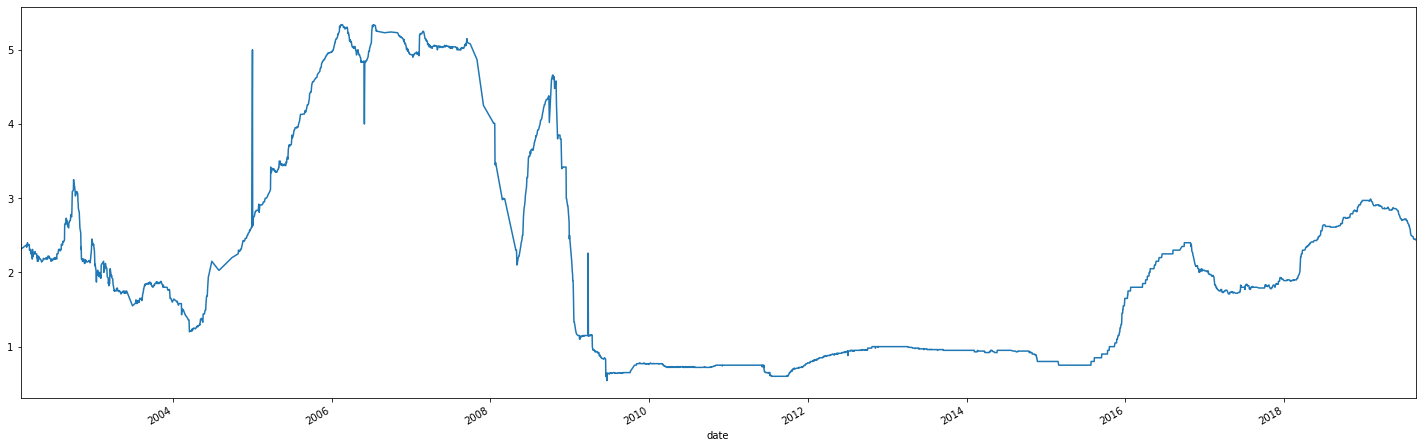

In [337]:
SAIBOR['saibor'].plot(figsize=(25,8))

In [338]:
SAIBOR['2005'].idxmax()

saibor   2005-01-02
dtype: datetime64[ns]

In [339]:
SAIBOR['2004-12-12':'2005-01-12']

,saibor
date,
2004-12-12,2.510
2004-12-13,2.520
2004-12-14,2.530
2004-12-16,2.535
2004-12-18,2.540
2004-12-19,2.560
2004-12-20,2.570
2004-12-21,2.560
2004-12-22,2.565


In [340]:
SAIBOR.loc['2005-01-02'] = SAIBOR.loc['2004-12-30']

In [341]:
SAIBOR.describe()

,saibor
count,4052.000000
mean,1.988958
std,1.393185
min,0.541500
25%,0.880000
50%,1.730000
75%,2.640000
max,5.340000


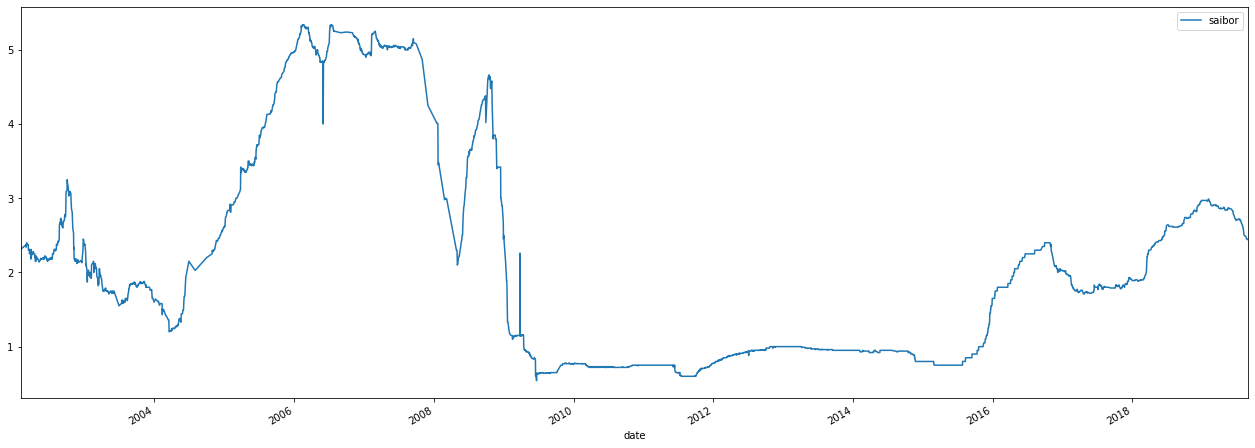

In [342]:
SAIBOR.plot(figsize=(22,8))

In [343]:
SAIBOR

,saibor
date,
2002-01-31,2.310
2002-02-27,2.370
2002-02-28,2.340
2002-03-04,2.400
2002-03-05,2.370
2002-03-06,2.370
2002-03-07,2.370
2002-03-11,2.375
2002-03-12,2.375


In [344]:
from statsmodels.tsa.filters.hp_filter import hpfilter

# Tuple unpacking
saibor_cycle, saibor_trend = hpfilter(SAIBOR['saibor'], lamb=1296000)

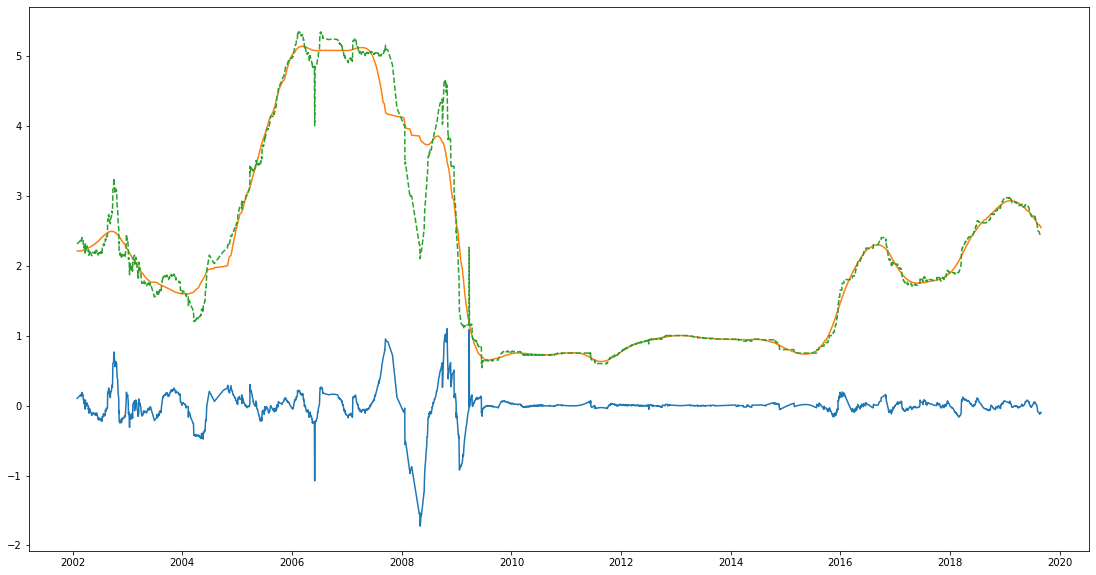

In [345]:
fig = plt.figure(figsize=(19,10))
ax = plt.plot(saibor_cycle)
ax = plt.plot(saibor_trend)
ax = plt.plot(SAIBOR, '--')


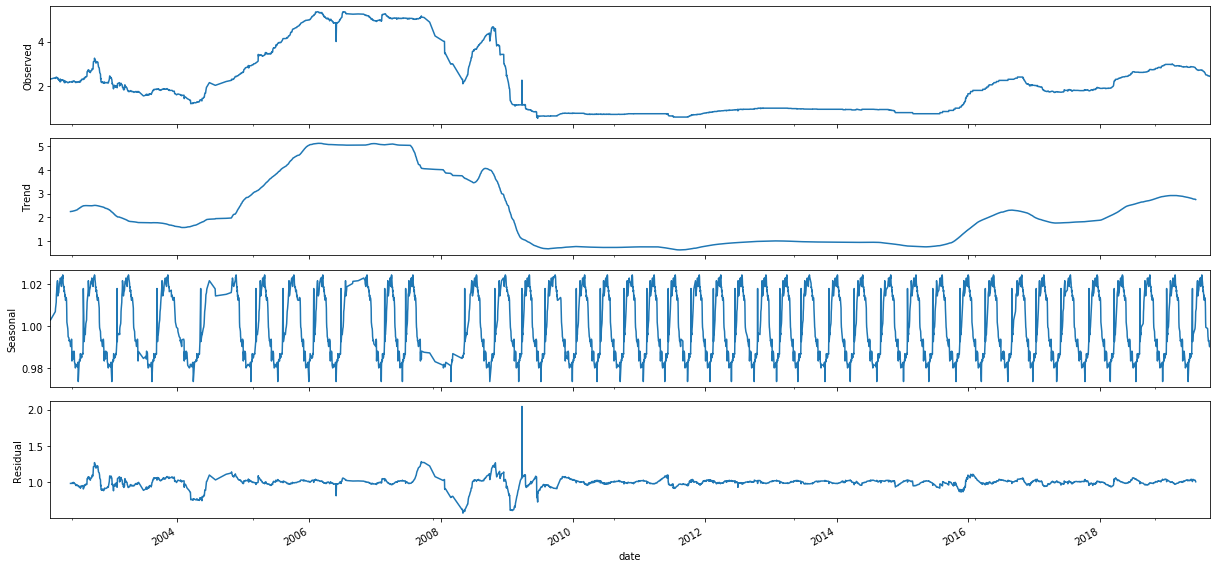

In [346]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

rcParams['figure.figsize'] = (17,8)
# result = seasonal_decompose(SAIBOR['saibor'], model='multiplicative', freq=None)  # model='mul' also works
result = seasonal_decompose(SAIBOR['saibor'], model='multiplicative', freq=100)
ax = result.plot();

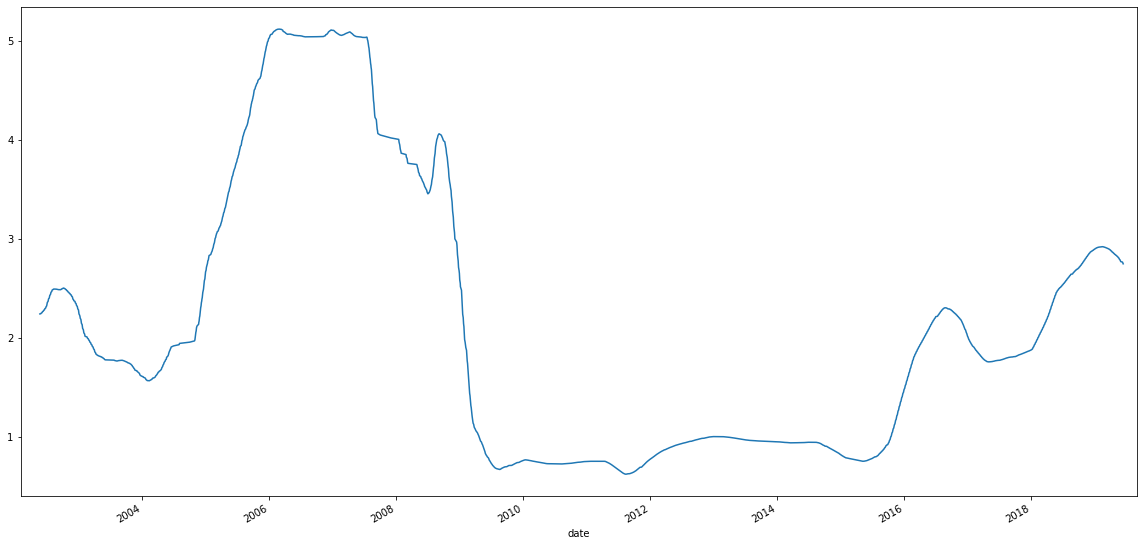

In [347]:
result.trend.plot(figsize=(20,10))

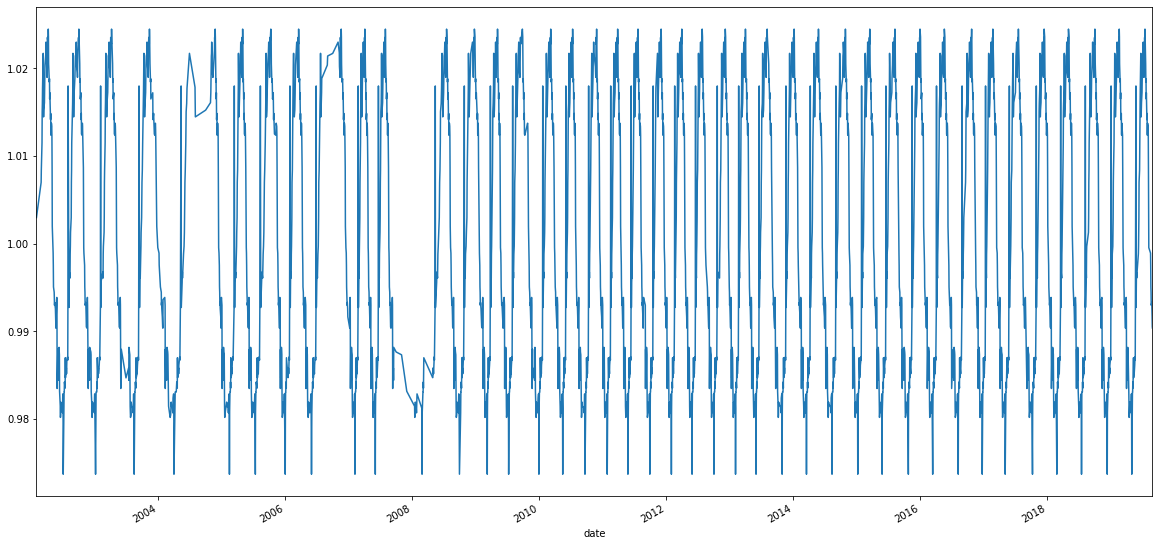

In [348]:
result.seasonal.plot(figsize=(20,10))

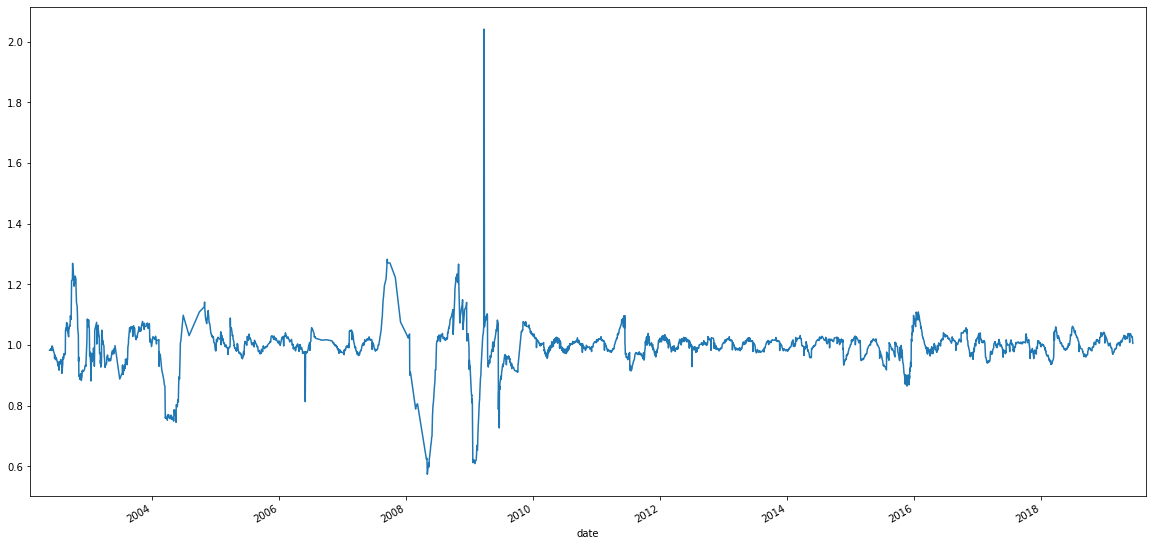

In [349]:
result.resid.plot(figsize=(20,10))

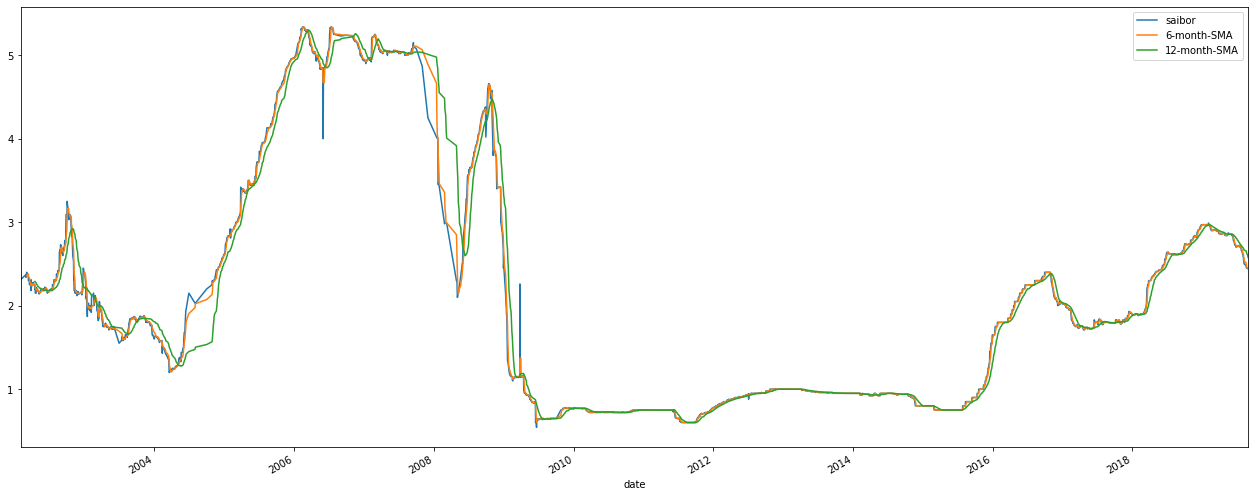

In [350]:
SAIBOR['6-month-SMA'] = SAIBOR['saibor'].rolling(window=5).mean()
SAIBOR['12-month-SMA'] = SAIBOR['saibor'].rolling(window=30).mean()
SAIBOR.plot(figsize=(22,9));

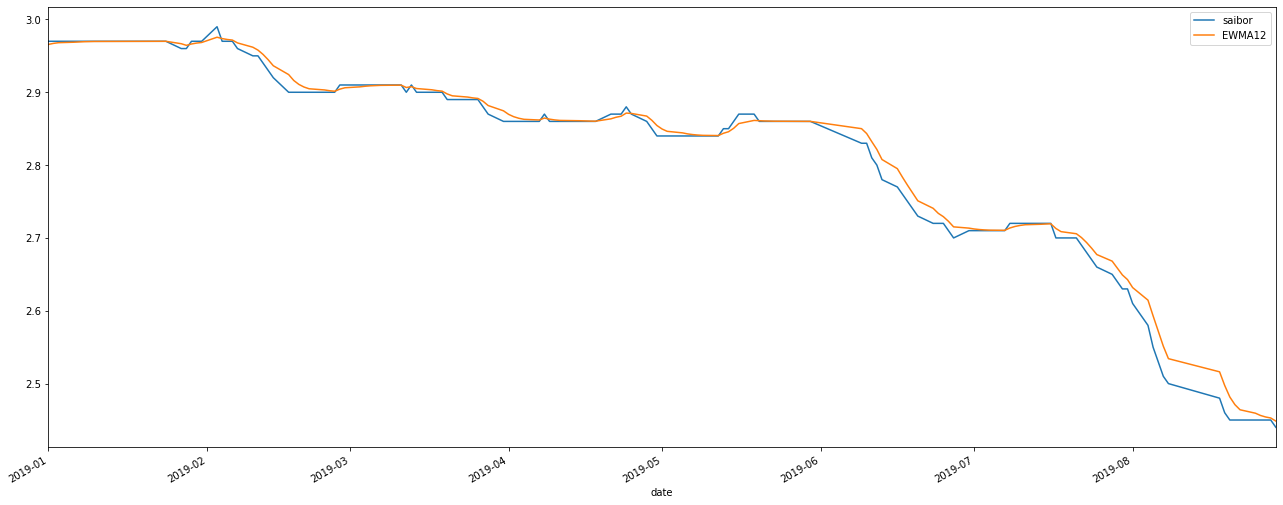

In [351]:
SAIBOR['EWMA12'] = SAIBOR['saibor'].ewm(span=5,adjust=False).mean()
SAIBOR.loc['2019'][['saibor', 'EWMA12']].plot(figsize=(22,9));

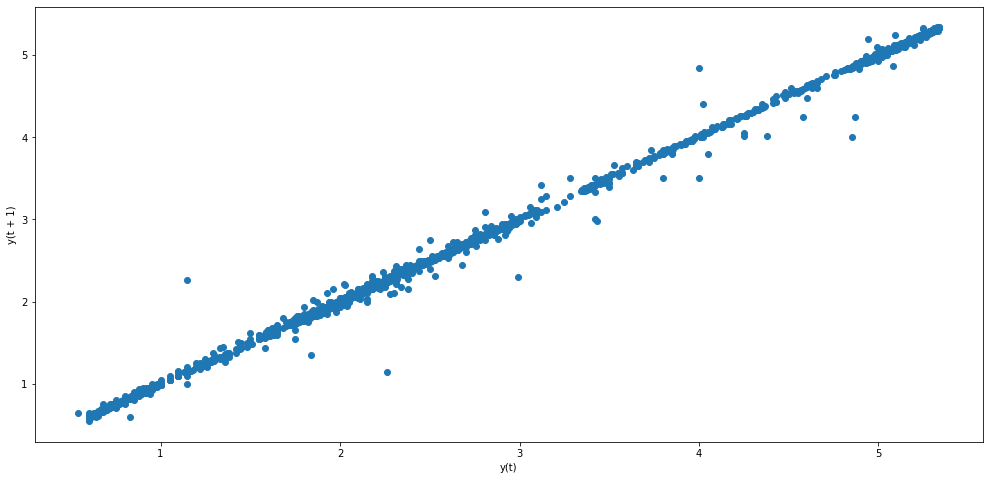

In [352]:
from pandas.plotting import lag_plot
lag_plot(SAIBOR['saibor']);

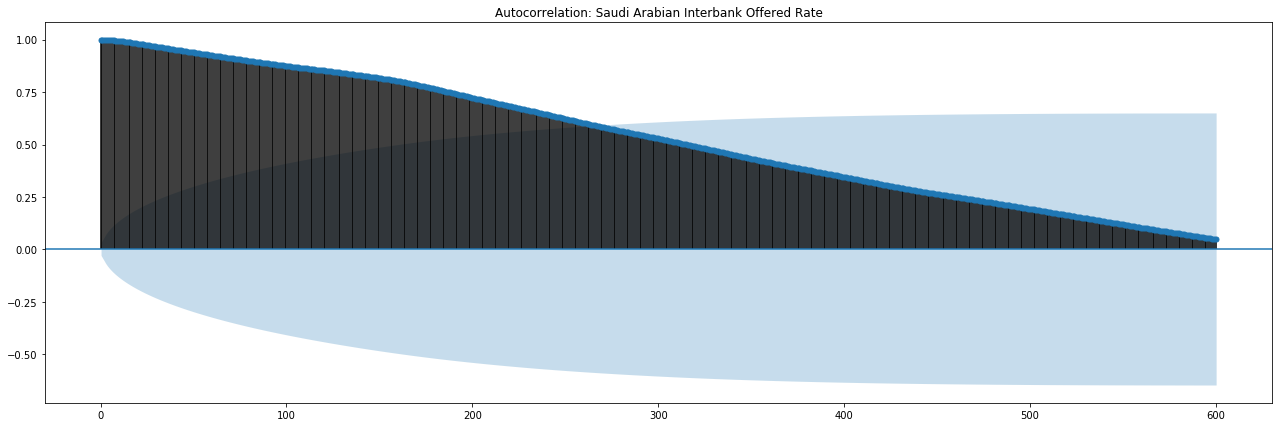

In [353]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

title = 'Autocorrelation: Saudi Arabian Interbank Offered Rate'
lags = 600
fig, ax = plt.subplots(figsize=(22,7))
# plot_acf(SAIBOR.saibor, title=title, lags=lags, use_vlines=False);
plot_acf(SAIBOR.saibor, title=title, lags=lags, ax=ax);

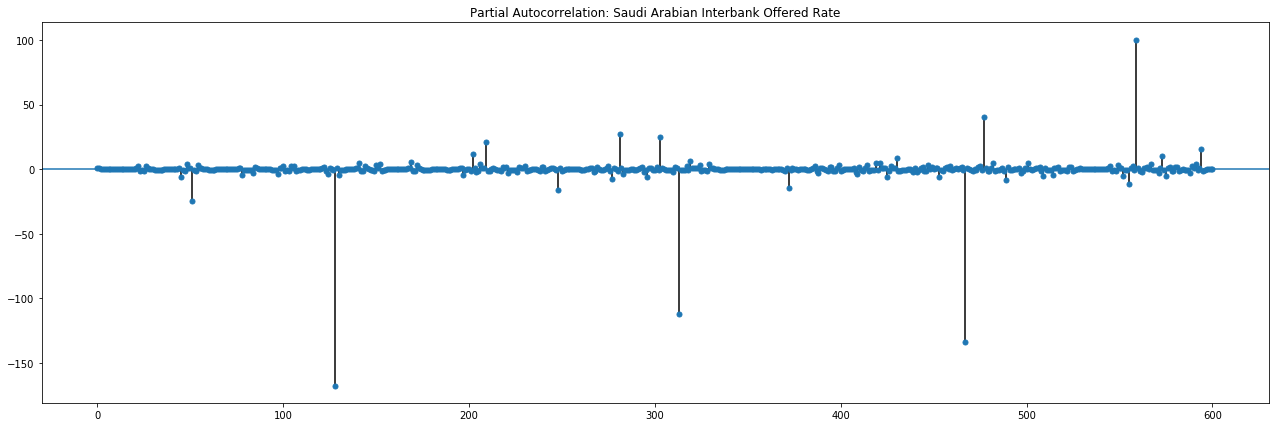

In [354]:
title = 'Partial Autocorrelation: Saudi Arabian Interbank Offered Rate'
lags = 600
fig, ax = plt.subplots(figsize=(22,7))

plot_pacf(SAIBOR.saibor, title=title, lags=lags, ax=ax);

# Forcasting: Autoregressive models

In [355]:
# Load specific forecasting tools
from statsmodels.tsa.ar_model import AR,ARResults

test = SAIBOR[['saibor']].iloc[-90:]
train = SAIBOR[['saibor']].iloc[:-90]

In [356]:
model = AR(train['saibor'])
AR1fit = model.fit(maxlag=1,method='mle')
print(f'Lag: {AR1fit.k_ar}')
print(f'Coefficients:\n{AR1fit.params}')

Lag: 1
Coefficients:
const        0.001555
L1.saibor    0.999302
dtype: float64


In [357]:
start=len(train)
end=len(train)+len(test)-1

In [358]:
predictions1 = AR1fit.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions').to_frame()

In [359]:
predictions1['date'] = test.index
predictions1.set_index('date', inplace=True)

In [360]:
df_AR = test.join(predictions1)

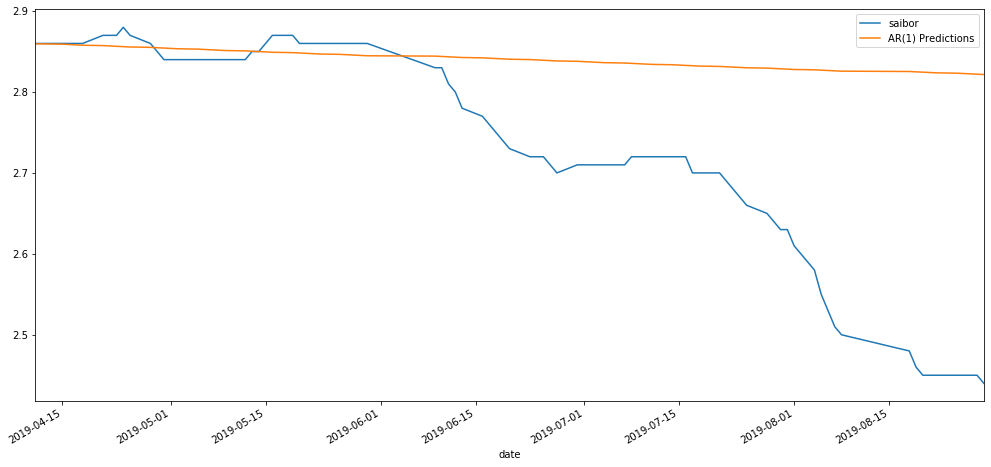

In [361]:
df_AR.plot()

In [362]:
# Recall that our model was already created above based on the training set
AR2fit = model.fit(maxlag=2,method='mle')
print(f'Lag: {AR2fit.k_ar}')
print(f'Coefficients:\n{AR2fit.params}')

Lag: 2
Coefficients:
const        0.001408
L1.saibor    0.832218
L2.saibor    0.167163
dtype: float64


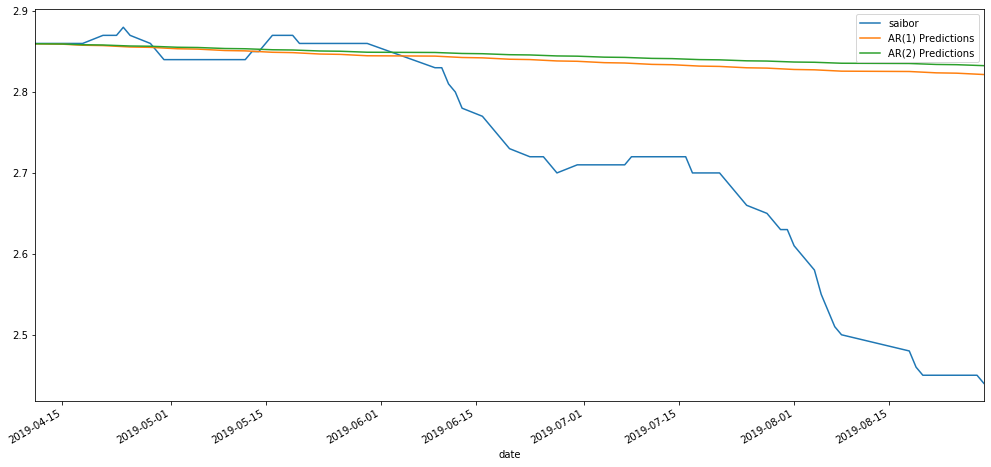

In [363]:
start=len(train)
end=len(train)+len(test)-1
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(2) Predictions').to_frame()
predictions2['date'] = test.index
predictions2.set_index('date', inplace=True)
df_AR = df_AR.join(predictions2)
df_AR.plot()

## Fit an AR(p) model where statsmodels chooses p
This time we'll omit the <tt>maxlag</tt> argument in <tt>AR.fit()</tt> and let statsmodels choose a p-value for us.

In [364]:
ARfit = model.fit(method='mle')
print(f'Lag: {ARfit.k_ar}')
print(f'Coefficients:\n{ARfit.params}')

Lag: 30
Coefficients:
const         0.001917
L1.saibor     0.776331
L2.saibor     0.216161
L3.saibor     0.074253
L4.saibor    -0.011433
L5.saibor     0.010589
L6.saibor     0.003873
L7.saibor     0.022304
L8.saibor     0.022393
L9.saibor    -0.042345
L10.saibor   -0.029674
L11.saibor   -0.010349
L12.saibor    0.028775
L13.saibor    0.023449
L14.saibor   -0.054179
L15.saibor   -0.024817
L16.saibor   -0.063675
L17.saibor   -0.009478
L18.saibor    0.024376
L19.saibor    0.049646
L20.saibor    0.029552
L21.saibor    0.008847
L22.saibor   -0.031036
L23.saibor    0.018181
L24.saibor   -0.049790
L25.saibor   -0.028369
L26.saibor    0.007352
L27.saibor    0.003821
L28.saibor    0.014029
L29.saibor    0.009957
L30.saibor    0.010352
dtype: float64


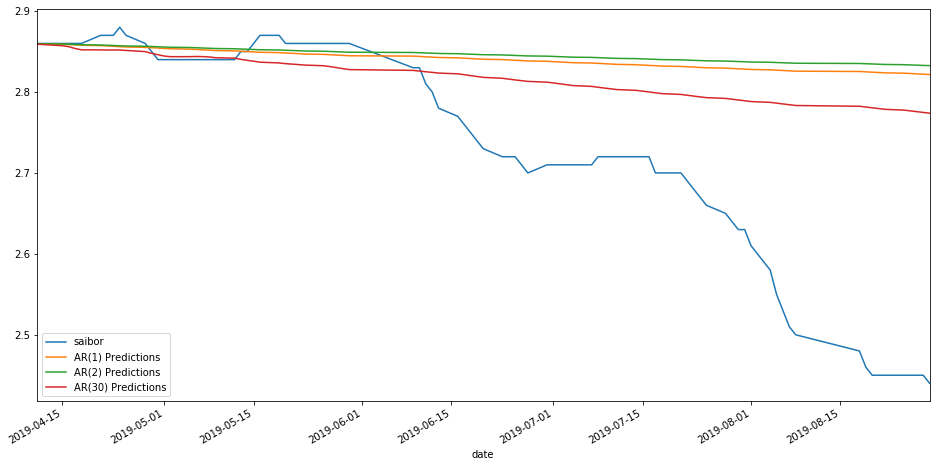

In [365]:
start = len(train)
end = len(train)+len(test)-1
rename = f'AR(30) Predictions'

predictions30 = ARfit.predict(start=start,end=end,dynamic=False).rename(rename).to_frame()
predictions30['date'] = test.index
predictions30.set_index('date', inplace=True)
df_AR = df_AR.join(predictions30)
df_AR.plot(figsize=(16,8))

In [223]:
df_AR.mean()

saibor                2.731111
AR(1) Predictions     2.840390
AR(2) Predictions     2.845996
AR(30) Predictions    2.816837
dtype: float64

In [225]:
AR1_error = sqrt(mean_squared_error(df_AR['saibor'], df_AR['AR(1) Predictions']))
AR1_error

0.16569623239757583

In [226]:
AR2_error = sqrt(mean_squared_error(df_AR['saibor'], df_AR['AR(2) Predictions']))
AR2_error

0.17157562798395687

In [228]:
AR30_error = sqrt(mean_squared_error(df_AR['saibor'], df_AR['AR(30) Predictions']))
AR30_error

0.14098187212542942

In [173]:
train

,saibor
date,
2002-01-31,2.310
2002-02-27,2.370
2002-02-28,2.340
2002-03-04,2.400
2002-03-05,2.370
2002-03-06,2.370
2002-03-07,2.370
2002-03-11,2.375
2002-03-12,2.375


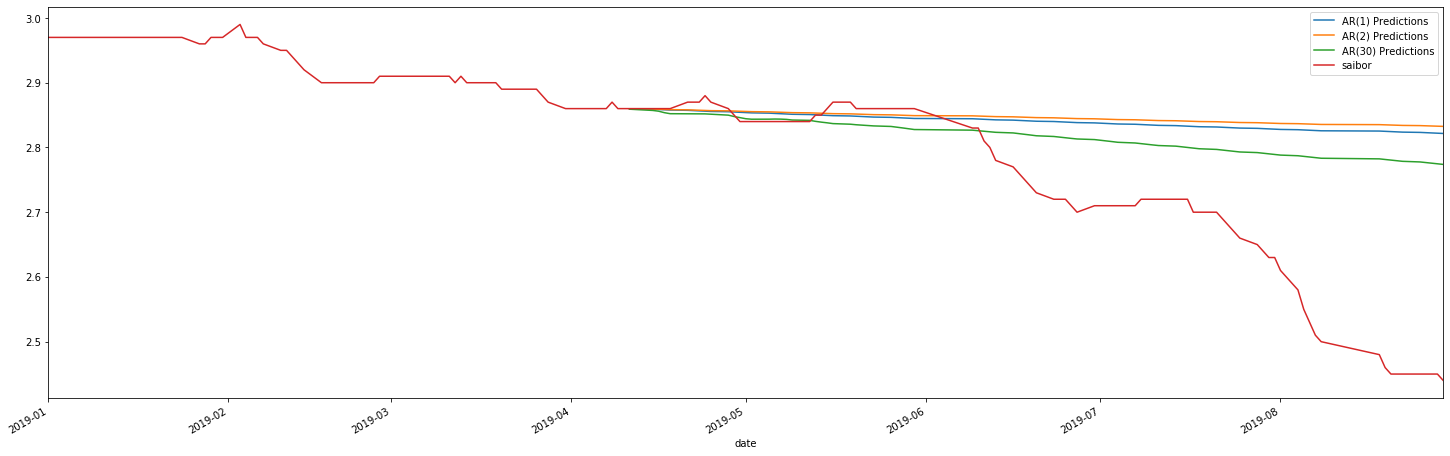

In [174]:
pd.concat([train, df_AR], axis=0, join='outer')['2019'].plot(figsize=(25,8))

# Dicky-Fuller Test for Stationarity

In [175]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [176]:
# Load specific forecasting tools
from statsmodels.tsa.api import VAR, DynamicVAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse

In [177]:
adf_test(SAIBOR['saibor'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -1.658526
p-value                    0.452598
# lags used               31.000000
# observations          4020.000000
critical value (1%)       -3.431978
critical value (5%)       -2.862259
critical value (10%)      -2.567153
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [178]:
adf_test(SAIBOR['saibor'].diff())

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.067638e+01
p-value                 4.043853e-19
# lags used             2.600000e+01
# observations          4.024000e+03
critical value (1%)    -3.431976e+00
critical value (5%)    -2.862259e+00
critical value (10%)   -2.567152e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


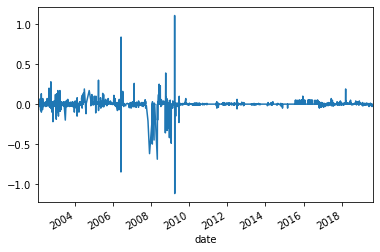

In [179]:
SAIBOR['saibor'].diff().plot()

# Forcasting: ARIMA Models

In [180]:
from pmdarima import auto_arima

### grid search for best p, d, q values

In [181]:
auto_arima(SAIBOR['saibor'],error_action='ignore').summary()

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 4052
Model:               SARIMAX(1, 1, 2)   Log Likelihood                6874.394
Date:                Tue, 10 Sep 2019   AIC                         -13738.788
Time:                        20:57:17   BIC                         -13707.255
Sample:                             0   HQIC                        -13727.618
                               - 4052                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.691e-06   8.23e-05     -0.045      0.964      -0.000       0.000
ar.L1          0.9429      0.005    191.273      0.000       0.933       0.953
ma.L1         -1.1550      0.005   -212.643      0.000      -1.166      -1.144
ma.L2          0.2631      0.003     80.408      0.000       0.257       0.270
sigma2         0.0020   4.74e-06    414.270      0.000       0.002       0.002
===================================================================================
Ljung-Box (Q):                      135.63   Jarque-Bera (JB):           8078720.46
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                            -1.72
Prob(H) (two-sided):                  0.00   Kurtosis:                       221.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [182]:
stepwise_fit = auto_arima(SAIBOR['saibor'], start_p=0, start_q=0,
                          max_p=10, max_d=10, max_q=10, m=1,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(0, 1, 0); AIC=-13444.207, BIC=-13431.594, Fit time=0.005 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-13556.167, BIC=-13537.247, Fit time=0.049 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-13543.190, BIC=-13524.270, Fit time=0.042 seconds
Fit ARIMA: order=(2, 1, 0); AIC=-13559.545, BIC=-13534.318, Fit time=0.058 seconds
Fit ARIMA: order=(2, 1, 1); AIC=-13710.592, BIC=-13679.058, Fit time=0.580 seconds
Fit ARIMA: order=(3, 1, 2); AIC=-13763.386, BIC=-13719.239, Fit time=1.290 seconds
Fit ARIMA: order=(2, 1, 2); AIC=-13742.073, BIC=-13704.232, Fit time=0.812 seconds
Fit ARIMA: order=(4, 1, 2); AIC=-13762.178, BIC=-13711.724, Fit time=1.568 seconds
Fit ARIMA: order=(3, 1, 1); AIC=-13732.840, BIC=-13695.000, Fit time=0.800 seconds
Fit ARIMA: order=(3, 1, 3); AIC=-13744.137, BIC=-13693.683, Fit time=4.050 seconds
Fit ARIMA: order=(4, 1, 3); AIC=-13762.055, BIC=-13705.295, Fit time=2.259 seconds
Total fit time: 11.518 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 4051
Model:                 ARIMA(3, 1, 2)   Log Likelihood                6888.693
Method:                       css-mle   S.D. of innovations              0.044
Date:                Tue, 10 Sep 2019   AIC                         -13763.386
Time:                        20:57:29   BIC                         -13719.239
Sample:                             1   HQIC                        -13747.747
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.749e-05      0.001      0.032      0.974      -0.002       0.002
ar.L1.D.y      1.5202      0.048     31.724      0.000       1.426       1.614
ar.L2.D.y     -0.4223      0.039    -10.878      0.000      -0.498      -0.346
ar.L3.D.y     -0.1308      0.024     -5.479      0.000      -0.178      -0.084
ma.L1.D.y     -1.7306      0.044    -38.990      0.000      -1.818      -1.644
ma.L2.D.y      0.7862      0.039     20.334      0.000       0.710       0.862
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1678           -0.1009j            1.1722           -0.0137
AR.2            1.1678           +0.1009j            1.1722            0.0137
AR.3           -5.5643           -0.0000j            5.5643           -0.5000
MA.1            1.1006           -0.2461j            1.1278           -0.0350
MA.2            1.1006           +0.2461j            1.1278            0.0350
-----------------------------------------------------------------------------
"""

In [245]:
model_ARIMA = ARIMA(train ,order=(3,1,2))
results = model_ARIMA.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.saibor   No. Observations:                 3961
Model:                 ARIMA(3, 1, 2)   Log Likelihood                6693.519
Method:                       css-mle   S.D. of innovations              0.045
Date:                Wed, 11 Sep 2019   AIC                         -13373.039
Time:                        01:57:27   BIC                         -13329.049
Sample:                             1   HQIC                        -13357.438
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0001      0.001      0.120      0.905      -0.002       0.002
ar.L1.D.saibor     1.5208      0.048     31.374      0.000       1.426       1.616
ar.L2.D.saibor    -0.4224      0.039    -10.785      0.000      -0.499      -0.346
ar.L3.D.saibor    -0.1312      0.024     -5.418      0.000      -0.179      -0.084
ma.L1.D.saibor    -1.7320      0.045    -38.588      0.000      -1.820      -1.644
ma.L2.D.saibor     0.7873      0.039     20.151      0.000       0.711       0.864
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1672           -0.1008j            1.1715           -0.0137
AR.2            1.1672           +0.1008j            1.1715            0.0137
AR.3           -5.5545           -0.0000j            5.5545           -0.5000
MA.1            1.1000           -0.2453j            1.1270           -0.0349
MA.2            1.1000           +0.2453j            1.1270            0.0349
-----------------------------------------------------------------------------
"""

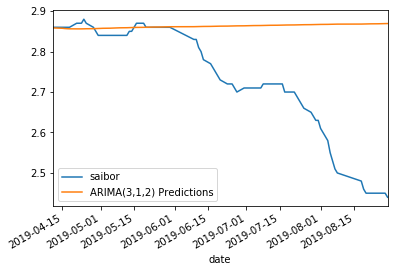

In [250]:
predictions_ARIMA = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(3,1,2) Predictions').to_frame()
df_ARIMA = test[['saibor']]
predictions_ARIMA['date'] = test.index
predictions_ARIMA.set_index('date', inplace=True)
df_ARIMA['ARIMA(3,1,2) Predictions'] = predictions_ARIMA
df_ARIMA.plot()

In [251]:
ARIMA_312_error = sqrt(mean_squared_error(df_ARIMA['saibor'], df_ARIMA['ARIMA(3,1,2) Predictions']))
ARIMA_312_error

0.19090446845704886

In [183]:
auto_arima(SAIBOR['saibor'],seasonal=True).summary()

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 4052
Model:               SARIMAX(1, 1, 2)   Log Likelihood                6874.394
Date:                Tue, 10 Sep 2019   AIC                         -13738.788
Time:                        20:57:45   BIC                         -13707.255
Sample:                             0   HQIC                        -13727.618
                               - 4052                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.691e-06   8.23e-05     -0.045      0.964      -0.000       0.000
ar.L1          0.9429      0.005    191.273      0.000       0.933       0.953
ma.L1         -1.1550      0.005   -212.643      0.000      -1.166      -1.144
ma.L2          0.2631      0.003     80.408      0.000       0.257       0.270
sigma2         0.0020   4.74e-06    414.270      0.000       0.002       0.002
===================================================================================
Ljung-Box (Q):                      135.63   Jarque-Bera (JB):           8078720.46
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                            -1.72
Prob(H) (two-sided):                  0.00   Kurtosis:                       221.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [254]:
model_SARIMAX = SARIMAX(train ,order=(1,1,2))
results = model_SARIMAX.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                 saibor   No. Observations:                 3962
Model:               SARIMAX(1, 1, 2)   Log Likelihood                6679.341
Date:                Wed, 11 Sep 2019   AIC                         -13350.683
Time:                        02:04:45   BIC                         -13325.546
Sample:                             0   HQIC                        -13341.768
                               - 3962                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9431      0.005    201.494      0.000       0.934       0.952
ma.L1         -1.1554      0.005   -223.259      0.000      -1.166      -1.145
ma.L2          0.2631      0.003     79.529      0.000       0.257       0.270
sigma2         0.0020   4.95e-06    405.673      0.000       0.002       0.002
===================================================================================
Ljung-Box (Q):                      133.27   Jarque-Bera (JB):           7578822.24
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                            -1.71
Prob(H) (two-sided):                  0.00   Kurtosis:                       217.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

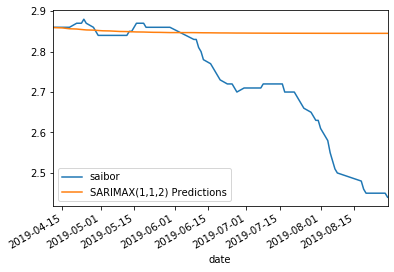

In [255]:
predictions_SARIMAX = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMAX(1,1,2) Predictions').to_frame()
df_SARIMAX = test[['saibor']]
predictions_SARIMAX['date'] = test.index
predictions_SARIMAX.set_index('date', inplace=True)
df_SARIMAX['SARIMAX(1,1,2) Predictions'] = predictions_SARIMAX
df_SARIMAX.plot()

In [257]:
SARIMAX_112_error = sqrt(mean_squared_error(df_SARIMAX['saibor'], df_SARIMAX['SARIMAX(1,1,2) Predictions']))
SARIMAX_112_error

0.17647551020217966

In [368]:
df_SARIMAX['SARIMAX(1,1,2) Predictions'].mean()

2.847766279603371

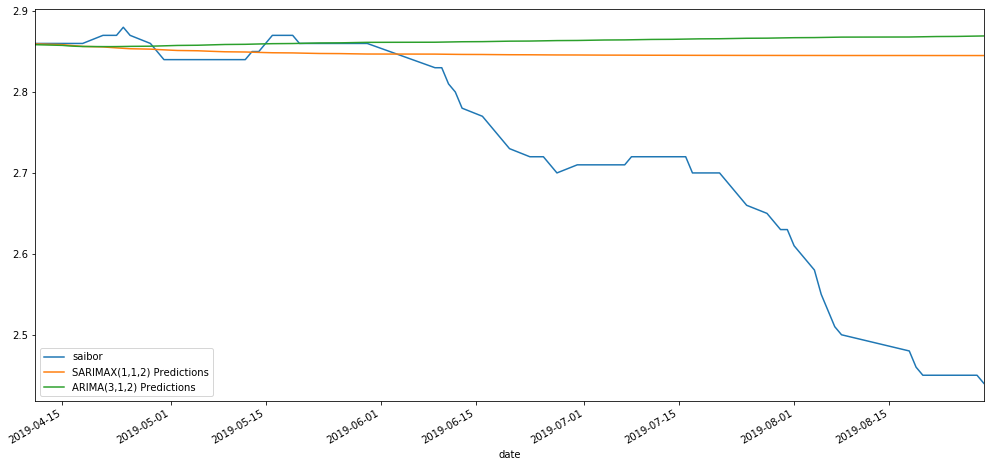

In [367]:
df_SARIMAX.plot(legend=True)
df_ARIMA['ARIMA(3,1,2) Predictions'].plot(legend=True)

In [369]:
df_ARIMA['ARIMA(3,1,2) Predictions'].mean()

2.8626997143913515

# Forcast: Long Short Term Memory

In [187]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

In [188]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [189]:
# define generator
n_input = 2
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
X,y = generator[0]

In [190]:
# Let's redefine to get 60 days back and then predict the next day

n_input = 60
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [194]:
n_input = 60
n_features = 1

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


In [195]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [196]:
# fit model
model.fit_generator(generator,epochs=50)

Epoch 1/50
3902/3902 [==============================] - 249s 64ms/step - loss: 0.0026
Epoch 2/50
3902/3902 [==============================] - 247s 63ms/step - loss: 3.5389e-04
Epoch 3/50
3902/3902 [==============================] - 247s 63ms/step - loss: 2.6668e-04
Epoch 4/50
3902/3902 [==============================] - 246s 63ms/step - loss: 2.1329e-04
Epoch 5/50
3902/3902 [==============================] - 248s 63ms/step - loss: 1.7552e-04
Epoch 6/50
3902/3902 [==============================] - 248s 63ms/step - loss: 1.5626e-04
Epoch 7/50
3902/3902 [==============================] - 247s 63ms/step - loss: 1.5554e-04
Epoch 8/50
3902/3902 [==============================] - 246s 63ms/step - loss: 1.4401e-04
Epoch 9/50
3902/3902 [==============================] - 246s 63ms/step - loss: 1.3651e-04
Epoch 10/50
3902/3902 [==============================] - 247s 63ms/step - loss: 1.4035e-04
Epoch 11/50
3902/3902 [==============================] - 247s 63ms/step - loss: 1.3607e-04
Epoch 12/50


In [197]:
model.save('SAIBOR _model.h5')

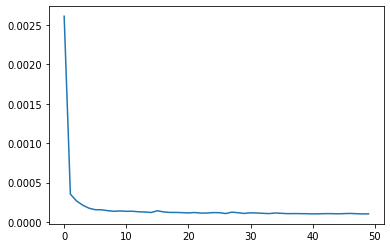

In [198]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [201]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [202]:
true_predictions = scaler.inverse_transform(test_predictions)

In [209]:
test_and_predictions = test
test_and_predictions['saibor_pred'] = true_predictions

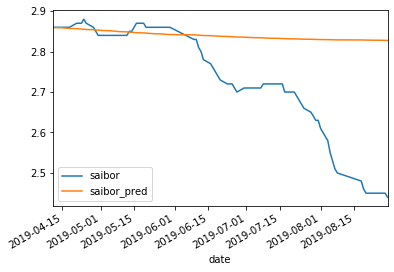

In [211]:
test_and_predictions.plot()

In [213]:
n_input = 10
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
# define model
model2 = Sequential()
model2.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mse')
model2.fit_generator(generator,epochs=10)

Epoch 1/10
3952/3952 [==============================] - 54s 14ms/step - loss: 0.0011
Epoch 2/10
3952/3952 [==============================] - 53s 13ms/step - loss: 3.3436e-04
Epoch 3/10
3952/3952 [==============================] - 53s 13ms/step - loss: 2.3813e-04
Epoch 4/10
3952/3952 [==============================] - 53s 13ms/step - loss: 1.9089e-04
Epoch 5/10
3952/3952 [==============================] - 53s 13ms/step - loss: 1.6589e-04
Epoch 6/10
3952/3952 [==============================] - 54s 14ms/step - loss: 1.6247e-04
Epoch 7/10
3952/3952 [==============================] - 53s 13ms/step - loss: 1.4254e-04
Epoch 8/10
3952/3952 [==============================] - 53s 13ms/step - loss: 1.5365e-04
Epoch 9/10
3952/3952 [==============================] - 53s 14ms/step - loss: 1.4244e-04
Epoch 10/10
3952/3952 [==============================] - 53s 13ms/step - loss: 1.3550e-04


In [214]:
model2.save('SAIBOR _model.h5')

In [215]:
true_predictions2 = scaler.inverse_transform(test_predictions)
test_and_predictions['saibor_pred2'] = true_predictions2

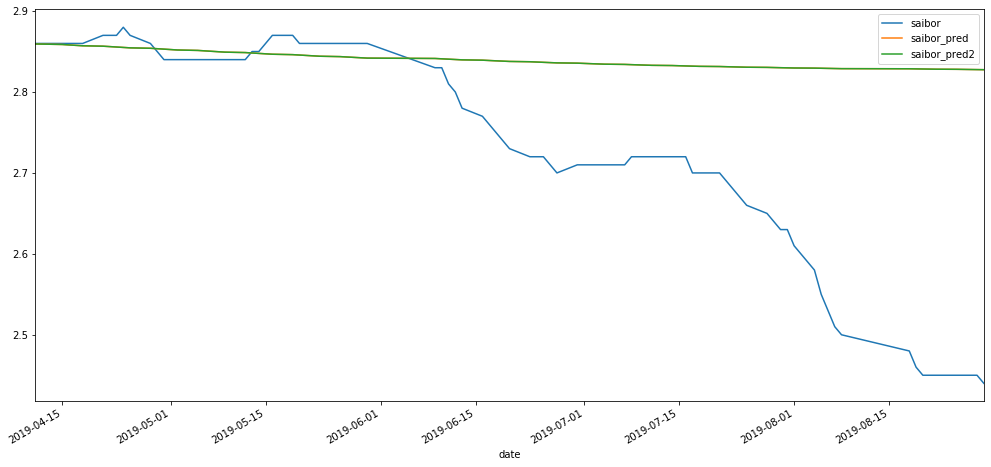

In [370]:
test_and_predictions.plot()

In [229]:
LTMS1_error = sqrt(mean_squared_error(test_and_predictions['saibor'], test_and_predictions['saibor_pred']))
LTMS1_error

0.16685947442106266

In [230]:
LTMS2_error = sqrt(mean_squared_error(test_and_predictions['saibor'], test_and_predictions['saibor_pred2']))
LTMS2_error

0.16685947442106266

In [371]:
test_and_predictions['saibor_pred'].mean()

2.839769163205723

In [372]:
test_and_predictions['saibor_pred2'].mean()

2.839769163205723

In [259]:
df_stocks = pd.read_csv('buy_backs_stocks.csv')

In [261]:
df_stocks.columns

Index(['Unnamed: 0', 'name', 'open', 'close', 'high', 'low', 'volume'], dtype='object')

In [263]:
df_stocks.rename(columns={'Unnamed: 0':'date'}, 
                 inplace=True)

In [272]:
df_stocks.set_index('date', drop=True, inplace=True)

In [293]:
cisco = df_stocks[df_stocks['name'] == 'CSCO']
cisco_10 = cisco['2010-10-10':]
cisco_10

,name,open,close,high,low,volume
date,,,,,,
2010-10-11,CSCO,22.47,22.47,22.65,22.38,28434492.0
2010-10-12,CSCO,22.35,22.62,22.75,22.27,35299048.0
2010-10-13,CSCO,22.93,23.18,23.40,22.83,66127092.0
2010-10-14,CSCO,23.30,23.07,23.30,22.85,38847136.0
2010-10-15,CSCO,23.27,23.36,23.40,23.00,50265796.0
2010-10-18,CSCO,23.35,23.30,23.50,23.23,40615236.0
2010-10-19,CSCO,23.05,22.97,23.18,22.76,53769368.0
2010-10-20,CSCO,22.91,23.40,23.58,22.91,44947212.0
2010-10-21,CSCO,23.48,23.26,23.55,22.98,38509136.0


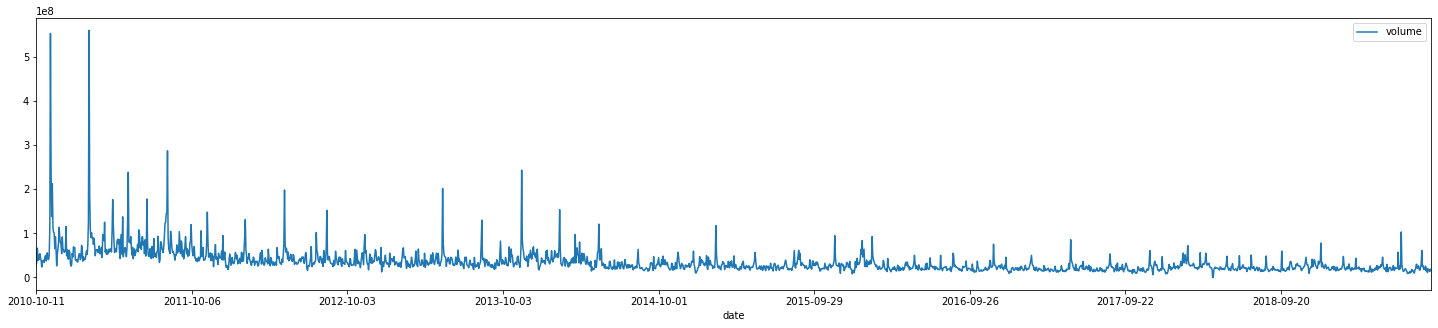

In [285]:
cisco_10[['volume']].plot(figsize=(25,5))

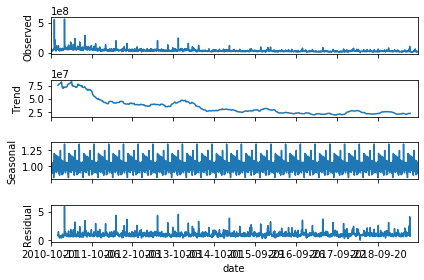

In [287]:
result = seasonal_decompose(cisco_10[['volume']], model='multiplicative', freq=90)
ax = result.plot();

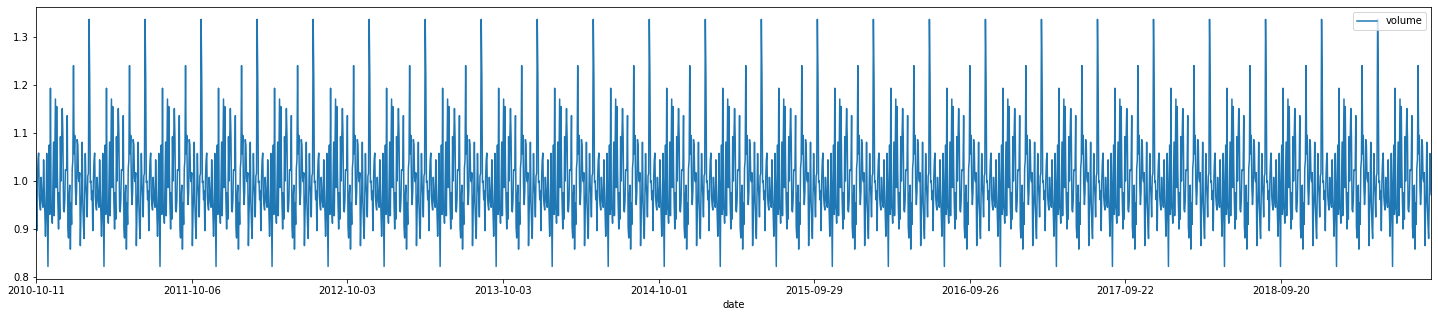

In [291]:
result.seasonal.plot(figsize=(25,5));

In [292]:
cisco_10.resample('M', on='date').sum()

KeyError: 'The grouper name date is not found'

In [373]:
SAIBOR.saibor.max()

5.34

In [374]:
SAIBOR.saibor.min()

0.5415

In [375]:
SAIBOR.saibor.mean()

1.9889578603158893

In [376]:
SAIBOR.saibor.std()

1.3931851080002358